In [1]:
import tensorflow as tf
from tensorflow import keras
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

import numpy as np

print(tf.__version__)

import nltk
nltk.download('punkt')
from nltk import word_tokenize
sno = nltk.stem.SnowballStemmer('english')

1.11.0
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
#MAPPING SENTENCES TO LIBRARY
import json
word_index = keras.datasets.imdb.get_word_index()

#declare trainData as an empty list
trainData = []
trainLabels = []

nonfunctional = 0
functional = 0
    
#temp list for each sentence
tempList = []

func = []
nonfunc = []

#this is the number of unique requirements in the data
STOP = 1300

with open("Consolidated_data.txt","r") as f:
    
    
    #read data-file line by line
    with open("libraryStemmed2.json", "r") as l:
        data = json.load(l)
        
        
        for line in f:
            #find where class begins
            front = line.find("\"class\":\"")
            #find where class ends (where sentence begins)
            end = line.find("\",\"sentence\":\"")
            #substring line based on front and end above
            reqClass = (line[(front+9):end]).lower()

            #sentence
            del tempList[:]
            temp = line.find("\"sentence\":\"")
            sentence = (line[(temp+12):-4]).lower()
            sentence = sentence.translate(None, '.,-\":;~!@#$%^&?[]{}<>`1234567890\\*()').strip()

            if "nonfunctional" in reqClass and (nonfunctional < STOP):
                if sentence in func:
                    continue
                nonfunc.append(sentence)
                nonfunctional +=1
                trainLabels.append(0)
                for x in sentence.split(' '):
                    x = unicode(x, 'utf-8')
                    x = sno.stem(x)
                    if x in data:
                        tempList.append(data[x])
                    else:
                        tempList.append(1)
                trainData.append(tempList[:])
            elif "functional" in reqClass and (functional < STOP):
                if sentence in nonfunc:
                    continue
                func.append(sentence)
                functional +=1
                trainLabels.append(1)
                for x in sentence.split(' '):
                    x = unicode(x, 'utf-8')
                    x = sno.stem(x)
                    if x in data:
                        tempList.append(data[x])
                    else:
                        tempList.append(1)
                trainData.append(tempList[:])
            else:
                if (nonfunctional < STOP):
                    if sentence in func:
                        continue
                    nonfunc.append(sentence)
                    nonfunctional +=1
                    trainLabels.append(0)
                    for x in sentence.split(' '):
                        x = unicode(x, 'utf-8')
                        x = sno.stem(x)
                        if x in data:
                            tempList.append(data[x])
                        #UNCOMMENTING IS STRONGLY NOT RECOMMENDED
                        else:
                            tempList.append(1)
                    trainData.append(tempList[:])
                    

In [3]:
trainData, trainLabels = shuffle(trainData, trainLabels)

In [4]:
from random import randint

testData = []
testLabels = []

nonfunctional = 0
functional = 0

testDataNumber = 200

for x in trainLabels:
    if x == 1 and functional < testDataNumber:
        functional += 1
        testData.append(trainData.pop(0))
        testLabels.append(trainLabels.pop(0))
    else:
        if x == 0 and nonfunctional < testDataNumber:
            nonfunctional += 1
            testData.append(trainData.pop(0))
            testLabels.append(trainLabels.pop(0))

In [5]:
print(trainLabels.count(1))
print(trainLabels.count(0))
print(testLabels.count(1))
print(testLabels.count(0))

1101
1099
199
201


In [6]:
#randomizing data in two arrays without disrupting the order
testData, testLabels = shuffle(testData, testLabels)

In [7]:
#sanity check
#those should NOT be the same
print testData[0]
print trainData[0]

[198, 1, 23, 93, 62, 223, 45, 1, 72, 1, 62, 846, 130, 72, 1, 45, 1, 90, 384, 1, 38, 23, 17, 1, 1, 23, 93, 1, 1039, 554, 1, 1, 1039, 252, 1, 1, 45, 972, 266, 1, 1, 84, 1, 1, 1, 160, 1, 1, 17, 891, 1252, 1, 45]
[1, 9, 1, 1, 26, 1, 231, 778, 465, 79, 1, 156, 1, 1, 764, 1, 1, 156, 1, 1, 1, 1, 1, 1554]


In [8]:
# A dictionary mapping words to an integer index
word_index = json.load(open('libraryStemmed2.json', 'r'))

word_index["<PAD>"] = 0
word_index["<UNK>"] = 1 # unknown

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

In [9]:
print(decode_review(trainData[0]))
print(trainLabels[0])

<UNK> system <UNK> <UNK> abil <UNK> determin cost per administr <UNK> drug <UNK> <UNK> purchas <UNK> <UNK> drug <UNK> <UNK> <UNK> <UNK> <UNK> increment
0


In [10]:
trainData = keras.preprocessing.sequence.pad_sequences(trainData,
                                                        value=word_index["<PAD>"],
                                                        padding='post',
                                                        maxlen=32)

testData = keras.preprocessing.sequence.pad_sequences(testData,
                                                       value=word_index["<PAD>"],
                                                       padding='post',
                                                       maxlen=32)

In [11]:
vocab_size = 2005

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 16))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(16, activation=tf.nn.relu))
model.add(keras.layers.Dense(1, activation=tf.nn.sigmoid))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          32080     
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 32,369
Trainable params: 32,369
Non-trainable params: 0
_________________________________________________________________


In [12]:
model.compile(optimizer=tf.train.AdamOptimizer(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [13]:
x_val = trainData[2000:]
partial_x_train = trainData[:2000]

y_val = trainLabels[2000:]
partial_y_train = trainLabels[:2000]

In [14]:
print(model.evaluate(testData, testLabels))

400/400 [==============================] - 0s 486us/step
[0.693347589969635, 0.5]


In [15]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=50,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Train on 2000 samples, validate on 200 samples
Epoch 1/50
2000/2000 [==============================] - 1s 284us/step - loss: 0.6935 - acc: 0.5025 - val_loss: 0.6923 - val_acc: 0.5450
Epoch 2/50
2000/2000 [==============================] - 0s 21us/step - loss: 0.6922 - acc: 0.5790 - val_loss: 0.6923 - val_acc: 0.5350
Epoch 3/50
2000/2000 [==============================] - 0s 21us/step - loss: 0.6911 - acc: 0.5875 - val_loss: 0.6919 - val_acc: 0.5300
Epoch 4/50
2000/2000 [==============================] - 0s 21us/step - loss: 0.6899 - acc: 0.5960 - val_loss: 0.6913 - val_acc: 0.5400
Epoch 5/50
2000/2000 [==============================] - 0s 21us/step - loss: 0.6887 - acc: 0.6005 - val_loss: 0.6907 - val_acc: 0.5400
Epoch 6/50
2000/2000 [==============================] - 0s 23us/step - loss: 0.6875 - acc: 0.6100 - val_loss: 0.6902 - val_acc: 0.5400
Epoch 7/50
2000/2000 [==============================] - 0s 24us/step - loss: 0.6861 - acc: 0.6165 - val_loss: 0.6896 - val_acc: 0.5450
Epoch 8

In [16]:
print(model.evaluate(testData, testLabels))

400/400 [==============================] - 0s 59us/step
[0.5410567378997803, 0.7525]


In [17]:
history_dict = history.history
history_dict.keys()

['acc', 'loss', 'val_acc', 'val_loss']

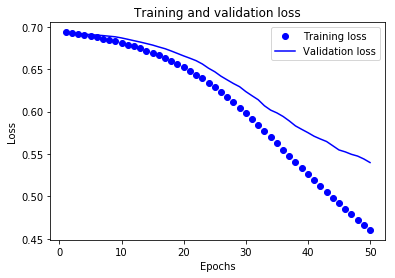

In [18]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

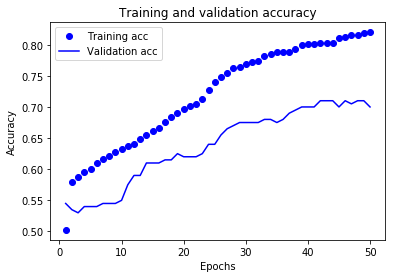

In [19]:
plt.clf()   # clear figure
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()